### Filtrado depo


In [1]:
%pip install pandas scikit-learn scikit-survival matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder  # Importar desde sklearn
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis, IPCRidge
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sksurv.svm import FastSurvivalSVM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Convertir a DataFrame
initial_df = pd.read_json('../Datos/2024-20/initial_state.json')


transactions_df = pd.read_csv('../Datos/2024-20/transactions.csv', parse_dates=['previous_time', 'current_time'], date_format='%Y-%m-%d %H.%M.%S')
# Restar 5 horas para que sea UTC-5 (grenwich-5 para que quede en colombianito)
transactions_df['previous_time'] = transactions_df['previous_time'] - pd.Timedelta(hours=5)
transactions_df['current_time'] = transactions_df['current_time'] - pd.Timedelta(hours=5)

print(f'initial_df={initial_df.shape},transactions_df={transactions_df.shape}')

# Filtrar transacciones hasta el 25 de julio de 2024
transactions_df = transactions_df[transactions_df['current_time'] <= '2024-07-26 00:00:00']

# Filtrar los deportes (donde course_class sea 'DEPO')
initial_df = initial_df[initial_df['class'] != 'DEPO']

print(f'initial_df={initial_df.shape},transactions_df={transactions_df.shape}')


transactions_df.tail()


initial_df=(6466, 18),transactions_df=(120007, 4)
initial_df=(6324, 18),transactions_df=(87720, 4)


,previous_time,current_time,nrc,delta_enrolled
87715,2024-07-25 22:21:17,2024-07-25 22:23:13,45202,1
87716,2024-07-25 22:21:17,2024-07-25 22:23:13,65772,1
87717,2024-07-25 22:27:06,2024-07-25 22:29:01,45202,1
87718,2024-07-25 22:31:00,2024-07-25 22:32:54,27904,1
87719,2024-07-25 22:31:00,2024-07-25 22:32:54,31010,-1


### Eliminar duplicados

In [3]:
print(f'initial_df={initial_df.shape},transactions_df={transactions_df.shape}')

# Eliminar por completo los NRCs duplicados, es decir, todas las filas que tengan NRC duplicados
initial_df = initial_df[~initial_df.duplicated(subset='nrc', keep=False)]

print(f'initial_df={initial_df.shape},transactions_df={transactions_df.shape}')

initial_df=(6324, 18),transactions_df=(87720, 4)
initial_df=(6324, 18),transactions_df=(87720, 4)


### Eliminar los que no estén en ambos lados


In [4]:
# Identificar NRCs en transactions_df que no están en initial_df
nrcs_initial = initial_df['nrc'].unique()
nrcs_transactions = transactions_df['nrc'].unique()
missing_nrcs = set(nrcs_transactions) - set(nrcs_initial)


# Filtrar transactions_df para eliminar los NRCs que no están en initial_df
transactions_df = transactions_df[~transactions_df['nrc'].isin(missing_nrcs)]

print(f'initial_df={initial_df.shape},transactions_df={transactions_df.shape}')


initial_df=(6324, 18),transactions_df=(86958, 4)


In [5]:
# Obtener los NRCs presentes en transactions_df
nrcs_transactions = transactions_df['nrc'].unique()

# Filtrar initial_df para conservar solo los NRCs que también están en transactions_df
initial_df_filtered = initial_df[initial_df['nrc'].isin(nrcs_transactions)]

print(f'initial_df={initial_df.shape},transactions_df={transactions_df.shape}')



initial_df=(6324, 18),transactions_df=(86958, 4)


### MEJORAR DURATION /CORREGIR EL TIEMPO FINAL CENSURADOS

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Función para crear intervalos de 30 minutos y asignar 1 o 0 en función de todos los horarios del curso
def create_time_bins(schedules):
    bins = np.zeros(48)  # 48 intervalos de 30 minutos en un día (24 horas * 2)
    
    # Iterar sobre todas las entradas en la lista de horarios
    for schedule in schedules:
        if schedule['time_ini'] is None or schedule['time_fin'] is None:
            # Si no hay tiempo de inicio o fin, ignorar esta entrada
            continue

        # Convertir time_ini y time_fin a minutos
        time_ini = int(schedule['time_ini'][:2]) * 60 + int(schedule['time_ini'][2:])  # Convertir a minutos
        time_fin = int(schedule['time_fin'][:2]) * 60 + int(schedule['time_fin'][2:])  # Convertir a minutos
        
        # Marcar los intervalos de 30 minutos correspondientes
        for i in range(48):  # Cada intervalo representa 30 minutos
            interval_start = i * 30
            interval_end = (i + 1) * 30
            # Comprobar si el curso se solapa con el bin en cualquier punto
            if not (time_fin <= interval_start or time_ini >= interval_end):
                bins[i] = 1
    return bins
#---------------------------------------------------------------------------------------------------------------------
####NOCHEEE
# Función corregida para calcular la duración en horas activas (8:00 am a 5:00 pm)
def calcular_duration_en_horas_activas(first_enroll_time, fill_time):

    # Si no hay tiempo de llenado, tomamos el tiempo actual como fin
    if pd.isna(fill_time):
        fill_time = transactions_df['current_time'].max()

    # Definir los horarios de inicio y fin de inscripción
    start_hour = 8
    end_hour = 17

    # Si el tiempo de llenado es antes de la inscripción, no hay tiempo válido
    if fill_time < first_enroll_time:
        return 0
    
    # Calcular la duración en el mismo día
    def calcular_horas_dia(dia_inicio, dia_fin):
        # Obtener el máximo entre la hora de inicio y el horario de inicio permitido
        inicio_efectivo = max(dia_inicio.hour + dia_inicio.minute / 60, start_hour)
        # Obtener el mínimo entre la hora de fin y el horario de fin permitido
        fin_efectivo = min(dia_fin.hour + dia_fin.minute / 60, end_hour)
        # Si el horario efectivo es válido (en el rango de 8 am a 5 pm)
        return max(0, fin_efectivo - inicio_efectivo)

    total_minutes = 0

    # Si ambos tiempos están en el mismo día
    if first_enroll_time.date() == fill_time.date():
        total_minutes += calcular_horas_dia(first_enroll_time, fill_time) * 60
    else:
        # Calcular las horas para el primer día
        first_day_end = pd.Timestamp(first_enroll_time.year, first_enroll_time.month, first_enroll_time.day, end_hour, 0, 0)
        total_minutes += calcular_horas_dia(first_enroll_time, first_day_end) * 60

        # Calcular las horas para los días intermedios
        next_day = first_enroll_time + pd.Timedelta(days=1)
        while next_day.date() < fill_time.date():
            # Si el siguiente día no es fin de semana
            if next_day.weekday() < 5:  # weekday() devuelve 0 para lunes y 4 para viernes
                total_minutes += (end_hour - start_hour) * 60
            next_day += pd.Timedelta(days=1)

        # Calcular las horas para el último día
        fill_day_start = pd.Timestamp(fill_time.year, fill_time.month, fill_time.day, start_hour, 0, 0)
        total_minutes += calcular_horas_dia(fill_day_start, fill_time) * 60

    return total_minutes


#--------------------------------------------------------------------------------------------------------------------------------
#### CORREGIR DURATION
# Inicializar una lista para almacenar los resultados
results = []

enrol_delta = 5

# Agrupar por NRC para calcular la duración y el evento
for nrc, group in transactions_df.groupby('nrc'):
    # Obtener el maxenrol del NRC correspondiente desde initial_df
    max_enrol = int(initial_df.loc[initial_df['nrc'] == nrc, 'maxenrol'].values[0])
    
    # Ordenar por tiempo actual para procesar en orden
    group = group.sort_values(by='current_time')

    # Calcular la inscripción acumulada
    group['cumulative_enrolled'] = group['delta_enrolled'].cumsum()

    # Encontrar el primer tiempo de inscripción y el tiempo de llenado
    first_enroll_time = group['current_time'].min()
    fill_time = group.loc[group['cumulative_enrolled'] >= max_enrol - enrol_delta, 'current_time'].min()

    # Definir el evento y la duración
    event = 0 if pd.isna(fill_time) else 1 

    # Calcular el duration usando solo las horas activas de inscripción
    duration = calcular_duration_en_horas_activas(first_enroll_time, fill_time)
    
    # Extraer datos adicionales desde initial_df
    schedules = initial_df.loc[initial_df['nrc'] == nrc, 'schedules'].values[0]
    course = initial_df.loc[initial_df['nrc'] == nrc, 'course'].values[0]
    course_level = int(str(course)[0])  # Tomar el primer número como el nivel del curso
    course_class = initial_df.loc[initial_df['nrc'] == nrc, 'class'].values[0]
    ptrmdesc = initial_df.loc[initial_df['nrc'] == nrc, 'ptrmdesc'].values[0]
    
    # Crear los time_bins para la hora
    time_bins = create_time_bins(schedules)
    
    # Extraer los días de la semana
    days_of_week = set(day for data in schedules for day in ['l', 'm', 'i', 'j', 'v', 's', 'd'] if data.get(day))
    
    # Agregar los resultados a la lista
    results.append({
        'nrc': nrc, 
        'first_enroll_time': first_enroll_time, 
        'fill_time': fill_time, 
        'duration': duration, 
        'event': event, 
        'time_bins': time_bins, 
        'days_of_week': days_of_week, 
        'course_level': course_level, 
        'course_class': course_class, 
        'ptrmdesc': ptrmdesc
    })

# Convertir la lista de resultados a un DataFrame
result_df = pd.DataFrame(results)

# Mostrar el resultado
result_df.head()


,nrc,first_enroll_time,fill_time,duration,event,time_bins,days_of_week,course_level,course_class,ptrmdesc
0,10004,2024-07-22 08:02:51,NaT,2158.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, v}",2,MATE,PERIODO 202420 - 16 SEMANAS
1,10005,2024-07-18 12:06:32,NaT,2994.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{l},4,MATE,PERIODO 202420 - 16 SEMANAS
2,10006,2024-07-18 18:24:09,NaT,2700.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},4,MATE,PERIODO 202420 - 16 SEMANAS
3,10016,2024-07-18 11:16:45,NaT,3044.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, l}",4,IIND,PERIODO 202420 - 16 SEMANAS
4,10017,2024-07-18 10:33:04,NaT,3087.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, v}",4,IIND,PERIODO 202420 - 16 SEMANAS


### 3000 censurados..

In [7]:
#de los 5000 datos, 3000 nulos


result_df['fill_time'].isna().value_counts()

fill_time
False    3397
True     2069
Name: count, dtype: int64

### preparación 1


In [8]:
import pandas as pd
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt


# Codificar los días de la semana como variables categóricas
days_expanded = result_df['days_of_week'].apply(lambda x: list(x)).explode()
days_one_hot = pd.get_dummies(days_expanded).groupby(level=0).sum()

# Crear etiquetas descriptivas para los intervalos de tiempo (30 minutos cada uno)
interval_labels = [f'{i//2:02}:{(i%2)*30:02}-{(i//2):02}:{((i%2)+1)*30:02}' for i in range(48)]

# Expandir los time_bins y crear un DataFrame con las etiquetas de tiempo
time_bins_expanded = pd.DataFrame(result_df['time_bins'].tolist(), columns=interval_labels)

# Eliminar las columnas que contienen solo ceros
time_bins_expanded = time_bins_expanded.loc[:, (time_bins_expanded != 0).any(axis=0)]

# Añadir las columnas codificadas al DataFrame original
result_df = result_df.join(days_one_hot)
result_df = result_df.join(time_bins_expanded)



# Convertir las columnas categóricas a tipo 'category'
result_df['course_class'] = result_df['course_class'].astype('category')
result_df['ptrmdesc'] = result_df['ptrmdesc'].astype('category')

class_categories = ['MATE', 'IIND', 'ECON', 'DERE', 'CPOL', 'ISIS', 'FISI', 'ANTR', 'ADMI', 'BIOL', 'PSIC', 'LENG', 'CHNA', 'MBIO', 'QUIM', 'IMEC', 'IELE', 'FILO', 'ICYA', 'MEDI', 'PSCL', 'MUSI', 'CBIO', 'DDER', 'MLIT', 'IBIO', 'CIDE', 'HIST', 'ARTI', 'EGOB', 'LITE', 'MPER', 'MSIN', 'GEOC', 'SPUB', 'DECA', 'MBIT', 'EDUC', 'STRA', 'CISO', 'HDIG', 'MHAR', 'MPAZ', 'MART', 'MINE', 'ARTE', 'INTL', 'MFIN', 'EPID', 'MGPU', 'CBCC', 'CBCO', 'CBPC', 'CBCA', 'FARH', 'CPER', 'DEIN', 'EPAH', 'MECU', 'CONT', 'DISO', 'DADM', 'MGEO', 'IDOC', 'ARQT', 'MIIA', 'ESCR', 'PSIQ', 'PMED', 'ARQU', 'DGIT', 'EMAT', 'DLIT', 'MDER', 'MISW', 'GLOB', 'DGGJ', 'MECA', 'DPRO', 'MDIS', 'MPCU', 'IQYA', 'MMER', 'PSIG', 'BCOM', 'FCIE', 'SOCI', 'MIMC', 'HART', 'BIOE', 'EECO', 'EMBA', 'GEST', 'MCLA', 'MGAD', 'MMBA', 'MSCM', 'PATO', 'MGAP', 'DCOM', 'DEMP', 'DENI', 'DEPI', 'DEPR', 'DPUB', 'DPUC', 'EPEM', 'ETRI', 'GPUB', 'LEGI', 'MADM', 'MGIT', 'MGLO', 'MGPA', 'MGPD', 'MIAD', 'MIFI', 'MMUS', 'MTRI', 'PEDI', 'DCHO', 'MAIA', 'IING', 'MINT']  # Categorías predefinidas para 'course_class'
ptrmdesc_categories = ['CURSOS MEDICINA - 21 SEMANAS',
 'PERIODO 202420 - 16 SEMANAS',
 'PERIODO NO RETIRABLE',
 'PRIMER CICLO - 8 SEMANAS',
 'SEGUNDO CICLO - 8 SEMANAS']  # Categorías predefinidas para 'ptrmdesc'

# Codificar 'course_class' y 'ptrmdesc' usando categorías fijas
encoder_class = OneHotEncoder(categories=[class_categories], sparse_output=False)
class_encoded = encoder_class.fit_transform(result_df[['course_class']])  # Asegurar 2D

encoder_ptrmdesc = OneHotEncoder(categories=[ptrmdesc_categories], sparse_output=False)
ptrmdesc_encoded = encoder_ptrmdesc.fit_transform(result_df[['ptrmdesc']])  # Asegurar 2D

# Crear la matriz de características (X) uniendo todas las variables: 
# horas, días de la semana, clase, ciclo, y nivel
X = np.hstack([
    time_bins_expanded.values,       # Hora (intervalos de 30 minutos)
    days_one_hot.values,             # Días de la semana
    class_encoded,                   # Clase (codificada)
    ptrmdesc_encoded,                # Ciclo (codificado)
    result_df[['course_level']].values  # Nivel del curso
])

# Escalar las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 1: Convertir la columna 'event' a tipo booleano
result_df['event'] = result_df['event'].astype(bool)

# Paso 2: Crear la variable objetivo 'y'
y = result_df[['event', 'duration']]
y = y.to_records(index=False)


# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,  # Características escaladas
    y,         # Variable objetivo
    test_size=0.2,  # Proporción de datos para el conjunto de prueba (20%)
    random_state=42,  # Para reproducibilidad
    stratify=y['event']  # Estratificar según el evento si es un problema de clasificación
)



### Reporte 2

### Probar varios modelos 3

/Users/lindurita/Tesis/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.54624e-19): result may not be accurate.
  delta = solve(
/Users/lindurita/Tesis/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.11151e-21): result may not be accurate.
  delta = solve(
/Users/lindurita/Tesis/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.01095e-20): result may not be accurate.
  delta = solve(
/Users/lindurita/Tesis/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.81562e-21): result may not be accurate.
  delta = solve(
/Users/lindurita/Tesis/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.22002e-20): result may not be accurate.
  delta = solve(
/Users/lindurita/Tes

CoxPHSurvivalAnalysis: Concordance Index = 0.7295444242973708
CoxnetSurvivalAnalysis: Concordance Index = 0.7317233989944779
IPCRidge failed: Input y contains infinity or a value too large for dtype('float64').


/Users/lindurita/Tesis/.venv/lib/python3.11/site-packages/sksurv/linear_model/aft.py:185: RuntimeWarning: divide by zero encountered in log
  super().fit(X, np.log(time), sample_weight=weights)


RandomSurvivalForest: Concordance Index = 0.7529980219236793
ExtraSurvivalTrees: Concordance Index = 0.7515577351026127
GradientBoostingSurvivalAnalysis: Concordance Index = 0.72995755377895
FastSurvivalSVM failed: observed time contains values smaller or equal to zero
                              Model  Concordance Index
0             CoxPHSurvivalAnalysis           0.729544
1            CoxnetSurvivalAnalysis           0.731723
2              RandomSurvivalForest           0.752998
3                ExtraSurvivalTrees           0.751558
4  GradientBoostingSurvivalAnalysis           0.729958


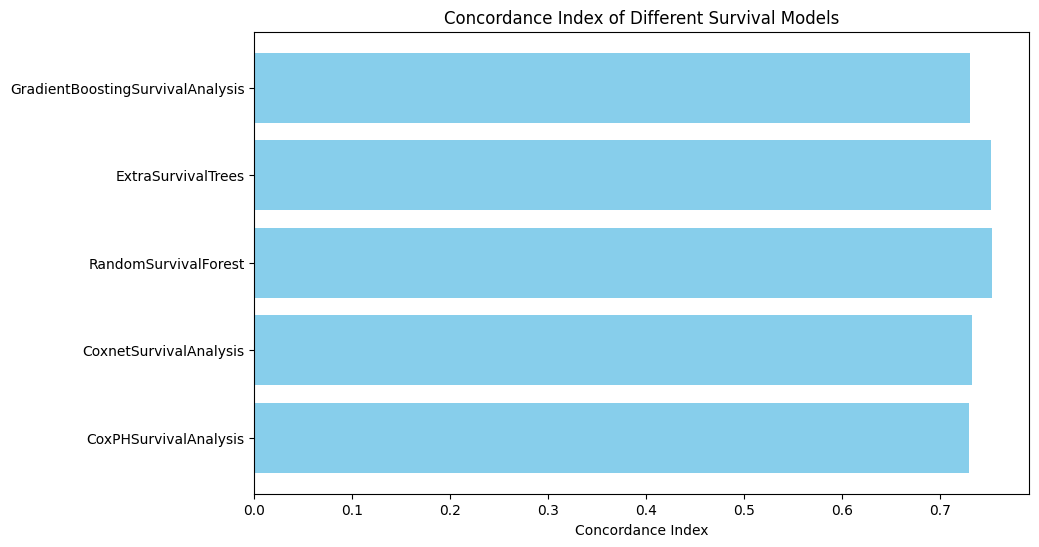

In [9]:
# Crear una lista con los modelos a probar
models = {
    "CoxPHSurvivalAnalysis": CoxPHSurvivalAnalysis(),
    "CoxnetSurvivalAnalysis": CoxnetSurvivalAnalysis(),
    "IPCRidge": IPCRidge(),
    "RandomSurvivalForest": RandomSurvivalForest(),
    "ExtraSurvivalTrees": ExtraSurvivalTrees(),
    "GradientBoostingSurvivalAnalysis": GradientBoostingSurvivalAnalysis(),
    "FastSurvivalSVM": FastSurvivalSVM()
}

# Almacenar los resultados en un diccionario
results = {}

# Entrenar cada modelo y calcular el índice de concordancia
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        cindex = concordance_index_censored(y_test['event'], y_test['duration'], model.predict(X_test))
        results[name] = cindex[0]  # Guardar el índice de concordancia
        print(f'{name}: Concordance Index = {cindex[0]}')
    except Exception as e:
        print(f'{name} failed: {e}')

# 3. Crear una tabla con las métricas

# Convertir el diccionario de resultados en un DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Concordance Index"])
print(results_df)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Concordance Index'], color='skyblue')
plt.xlabel('Concordance Index')
plt.title('Concordance Index of Different Survival Models')
plt.show()

In [10]:
%matplotlib inline

In [11]:
result_df

,nrc,first_enroll_time,fill_time,duration,event,time_bins,days_of_week,course_level,course_class,ptrmdesc,...,16:30-16:60,17:00-17:30,17:30-17:60,18:00-18:30,18:30-18:60,19:00-19:30,19:30-19:60,20:00-20:30,20:30-20:60,21:00-21:30
0,10004,2024-07-22 08:02:51,NaT,2158.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, v}",2,MATE,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10005,2024-07-18 12:06:32,NaT,2994.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{l},4,MATE,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10006,2024-07-18 18:24:09,NaT,2700.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{},4,MATE,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10016,2024-07-18 11:16:45,NaT,3044.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, l}",4,IIND,PERIODO 202420 - 16 SEMANAS,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10017,2024-07-18 10:33:04,NaT,3087.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{i, v}",4,IIND,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,73426,2024-07-18 16:04:58,NaT,2756.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{j},4,MIMC,PERIODO 202420 - 16 SEMANAS,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5462,73428,2024-07-18 14:36:43,NaT,2844.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{v},4,MGPU,PRIMER CICLO - 8 SEMANAS,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
5463,73431,2024-07-18 17:42:48,NaT,2700.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{v},4,MECA,PRIMER CICLO - 8 SEMANAS,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
5464,73432,2024-07-19 11:58:34,NaT,2462.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",{v},4,MECA,SEGUNDO CICLO - 8 SEMANAS,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [12]:
result_df[result_df['d']==1].join(initial_df,on='nrc',lsuffix='dani')

,nrcdani,first_enroll_time,fill_time,duration,event,time_bins,days_of_week,course_level,course_class,ptrmdescdani,...,enrolled,term,ptrm,ptrmdesc,seatsavail,campus,projenrl,schedules,instructors,attr
298,11618,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,11622,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,11624,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,11630,2024-07-22 10:05:12,NaT,2035.0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,11638,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5334,73240,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5335,73241,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5336,73242,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5345,73254,2024-07-22 10:05:12,2024-07-22 10:05:12,0.0,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{m, i, l, j, s, v, d}",3,MEDI,CURSOS MEDICINA - 21 SEMANAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import pickle
with open("model.pkl", "wb") as model_file:
    pickle.dump(models['RandomSurvivalForest'], model_file)
            
# Guardar el scaler
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

In [14]:
# Obtener los valores únicos de la columna 'course_class'
class_categories = result_df['course_class'].unique()

# Obtener los valores únicos de la columna 'ptrmdesc'
ptrmdesc_categories = result_df['ptrmdesc'].unique()

# Convertir a listas (opcional)
class_categories = class_categories.tolist()
ptrmdesc_categories = ptrmdesc_categories.tolist()



In [15]:
time_bins_expanded.values.shape

(5466, 30)

In [16]:
days_one_hot.values.shape

(5466, 7)

In [17]:
class_encoded.shape

(5466, 124)

In [18]:
ptrmdesc_encoded.shape

(5466, 5)

In [19]:
result_df[['course_level']].values.shape

(5466, 1)